In [303]:
from IPython.display import Image

import keras
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Lambda, Input, Dense, Conv2D, \
    Dropout, Conv2DTranspose, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydot
import networkx as nx
from itertools import product

In [304]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [305]:
img_rows, img_cols = x_train.shape[1], x_train.shape[2]
original_dim = img_rows * img_cols

In [306]:
batch_size = 128
latent_dim = 4
epochs = 30

In [307]:
# descripe this data as single-channel
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [308]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [309]:
inputs = Input(shape=input_shape,name='encoder_input')

In [310]:
l1 = Conv2D( 32, (3,3), strides=2, activation='relu', padding='same' )(inputs)
l2 = Conv2D( 64, (3,3), strides=2, activation='relu', padding='same' )(l1)
conv_shape = K.int_shape(l2)

In [311]:
l3 = Flatten()(l2)

In [312]:
l5 = Dense( 32, activation='relu' )(l3)

In [313]:
z_mean = Dense(latent_dim, name='z_mean')(l5)
z_log_var = Dense(latent_dim, name='z_log_var')(l5)

In [314]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [315]:
encoder = Model( inputs, [z_mean,z_log_var,z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_17[0][0]                  
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 3136)         0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
dense_26 (

In [316]:
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

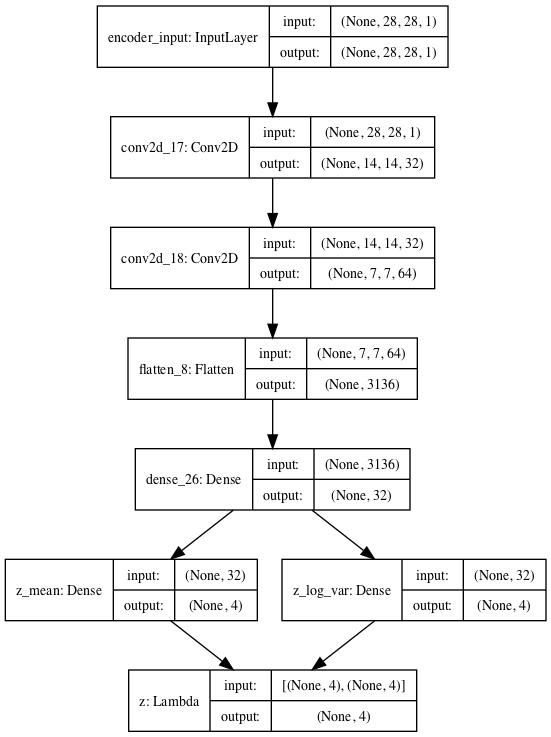

In [317]:
display(Image('vae_cnn_encoder.png'))

In [318]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
m1 = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(latent_inputs)
m2 = Reshape(conv_shape[1:])(m1)
m3 = Conv2DTranspose(64,(3,3),strides=2,activation='relu',padding='same')(m2)
m4 = Conv2DTranspose(32,(3,3),strides=2,activation='relu',padding='same')(m3)
outputs = Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same',name='decoder_output')(m4)

In [319]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 4)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 3136)              15680     
_________________________________________________________________
reshape_16 (Reshape)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 71,361
Trainable params: 71,361
Non-trainable params: 0
_________________________________________________________________


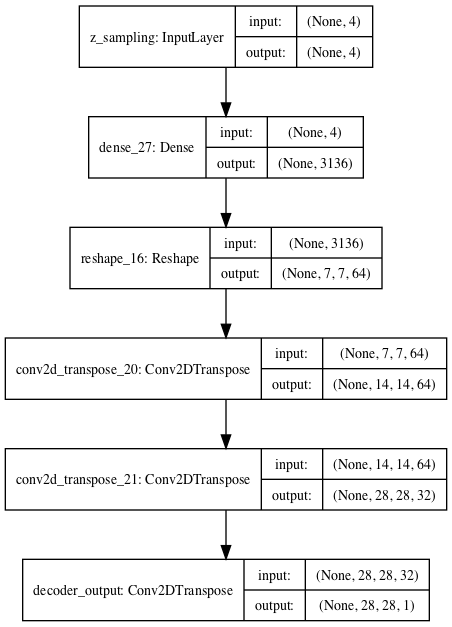

In [320]:
display(Image('vae_cnn_decoder.png'))

In [321]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_cnn')

In [322]:
models = (encoder, decoder)
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,to_file='vae_cnn.png',show_shapes=True)

/Users/jon/data/sandbox/keras/ve/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 119464    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         71361     
Total params: 190,825
Trainable params: 190,825
Non-trainable params: 0
_________________________________________________________________


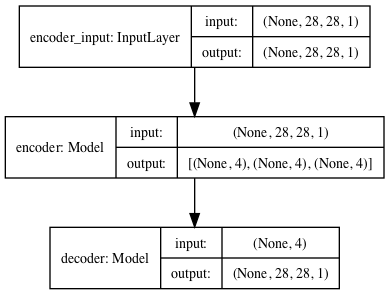

In [323]:
display(Image('vae_cnn.png'))

In [324]:
vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 44s 728us/step - loss: 209.0296 - val_loss: 173.5714
Epoch 2/30
60000/60000 [==============================] - 42s 701us/step - loss: 153.9252 - val_loss: 142.1683
Epoch 3/30
60000/60000 [==============================] - 42s 702us/step - loss: 139.7450 - val_loss: 137.2291
Epoch 4/30
60000/60000 [==============================] - 42s 704us/step - loss: 136.2857 - val_loss: 134.9236
Epoch 5/30
60000/60000 [==============================] - 43s 709us/step - loss: 134.4395 - val_loss: 134.2517
Epoch 6/30
60000/60000 [==============================] - 42s 707us/step - loss: 133.1151 - val_loss: 132.5575
Epoch 7/30
60000/60000 [==============================] - 43s 718us/step - loss: 132.2457 - val_loss: 131.8106
Epoch 8/30
60000/60000 [==============================] - 43s 710us/step - loss: 131.5145 - val_loss: 131.0553
Epoch 9/30
60000/60000 [==============================] - 43s 

In [325]:
z_mean,_,_ = encoder.predict(x_test,batch_size=batch_size)

In [326]:
d = pd.DataFrame( {'x':z_mean[:,0],'y':z_mean[:,1],'label':y_test} )

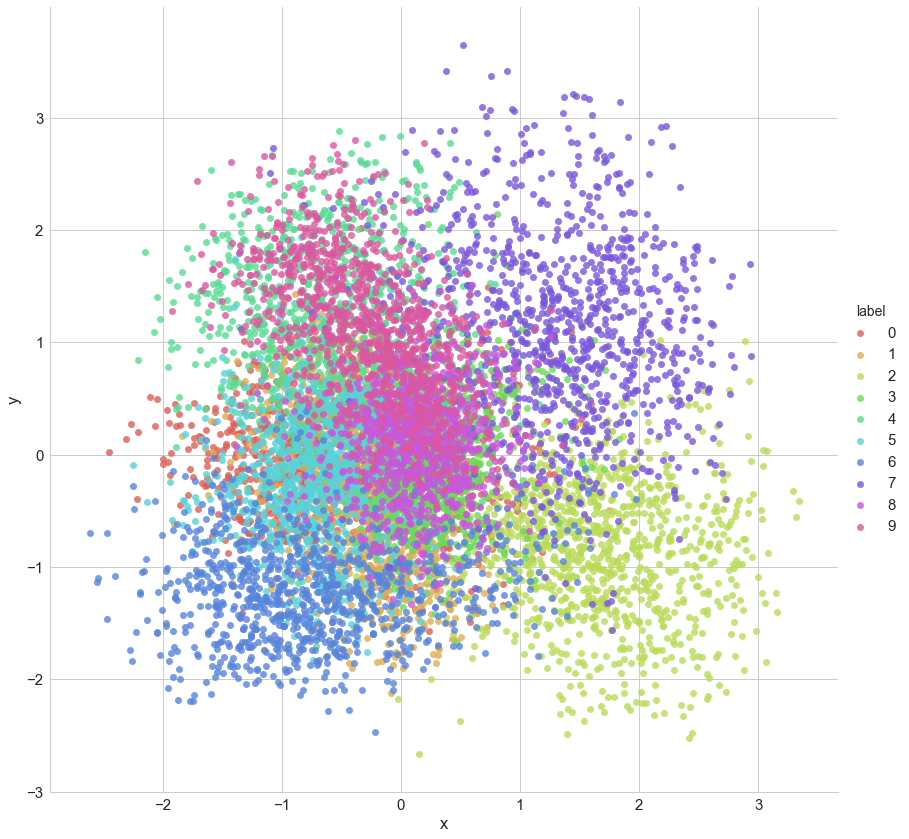

In [327]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set_context('notebook',font_scale=1.5)
sns.set_style('whitegrid')
with sns.color_palette('hls',10):
    sns.lmplot(x="x",y="y",data=d,hue='label',fit_reg=False,size=12)

In [328]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]+[0.0]*(latent_dim-2)])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

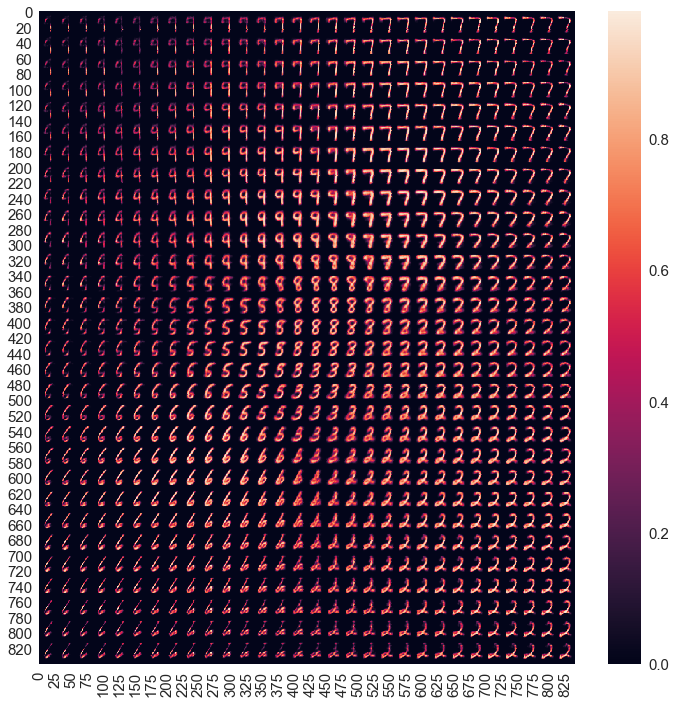

In [329]:
sns.heatmap(figure,xticklabels='auto')

In [330]:
# establish grid in latent space
_,_,z = encoder.predict(x_train)
z_limits = np.array( [ [ np.percentile(z[:,i],10), np.percentile(z[:,i],90) ] for i in range(latent_dim) ] )
# create nodes using a discretized latent space (-1,1)^n
min_z, max_z = -1,1
g = nx.Graph()
latent_samples = [3]*latent_dim
latent_points = np.array(list(product(*[np.linspace(min_z,max_z,latent_samples[i]) for i in range(latent_dim)])))

In [331]:
for i in range(latent_points.shape[0]):
    alpha = (latent_points[i,:]-min_z)/(max_z-min_z)
    true_z = alpha * (z_limits[:,1] - z_limits[:,0]) + z_limits[:,0]
    z_sample = np.array( [true_z] )
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    k = tuple( latent_points[i,j] for j in range(latent_dim) )
    g.add_node( k )
    g.nodes[k]['image_data'] = digit

In [332]:
maxsq = max_z*max_z + max_z/2.0
for i in range(latent_points.shape[0]):
    k1 = tuple( latent_points[i,k] for k in range(latent_dim) )
    for j in range(i+1,latent_points.shape[0]):
        dl = latent_points[i]-latent_points[j]
        if np.dot(dl,dl) < maxsq:
            k2 = tuple( latent_points[j,k] for k in range(latent_dim) )
            g.add_edge( k1, k2 )

In [333]:
gp = nx.nx_pydot.to_pydot(g)

In [334]:
import PIL
import PIL.Image
import base64
import os

# unfortunately graphviz doesn't support img from data
def get_base64_data( img_data ):
    img = PIL.Image.fromarray((img_data*255.0).astype('uint8'))
    img = img.convert('RGB')
    img.save('tmp.png')
    with open("tmp.png", "rb") as infile:
        enc = base64.b64encode(infile.read())
    return enc.decode('utf-8')

os.system('mkdir -p node_images')

def generate_image_file( _id, img_data ):
    img = PIL.Image.fromarray((img_data*255.0).astype('uint8'))
    img = img.convert('RGB')
    f = os.path.abspath('node_images/%s.png'%_id)
    img.save(f)
    return f

In [335]:
for i,(n,m) in enumerate(zip( gp.get_nodes(), g.nodes() )):
    dist = sum(x*x for x in eval(n.get_name().strip('"')))
    node_color = '%.2x' % (int(dist/latent_dim * 128.0 + 127.0))
    img = generate_image_file( i, g.nodes[m]['image_data'] )
    n.set_label( '<<table border="0"><tr><td><img src="%s"/></td></tr></table>>'%img )
    n.set_width(0.5)
    n.set_height(0.5)
    n.set_fixedsize(True)
    n.set_color('#e0e0ff')
    n.set_fillcolor('#%se0fb'%node_color)
    n.set_style('filled')
for e in gp.get_edges():
    e.set_color('#a0f0a0')

In [336]:
gp.set_overlap(False)
gp.set_outputorder('edgesfirst')
graphviz_prog = ['fdp','-GK=0.5']
graphviz_prog = ['twopi','-Granksep=0.72']
gp.write_png('tst.png',prog=graphviz_prog)

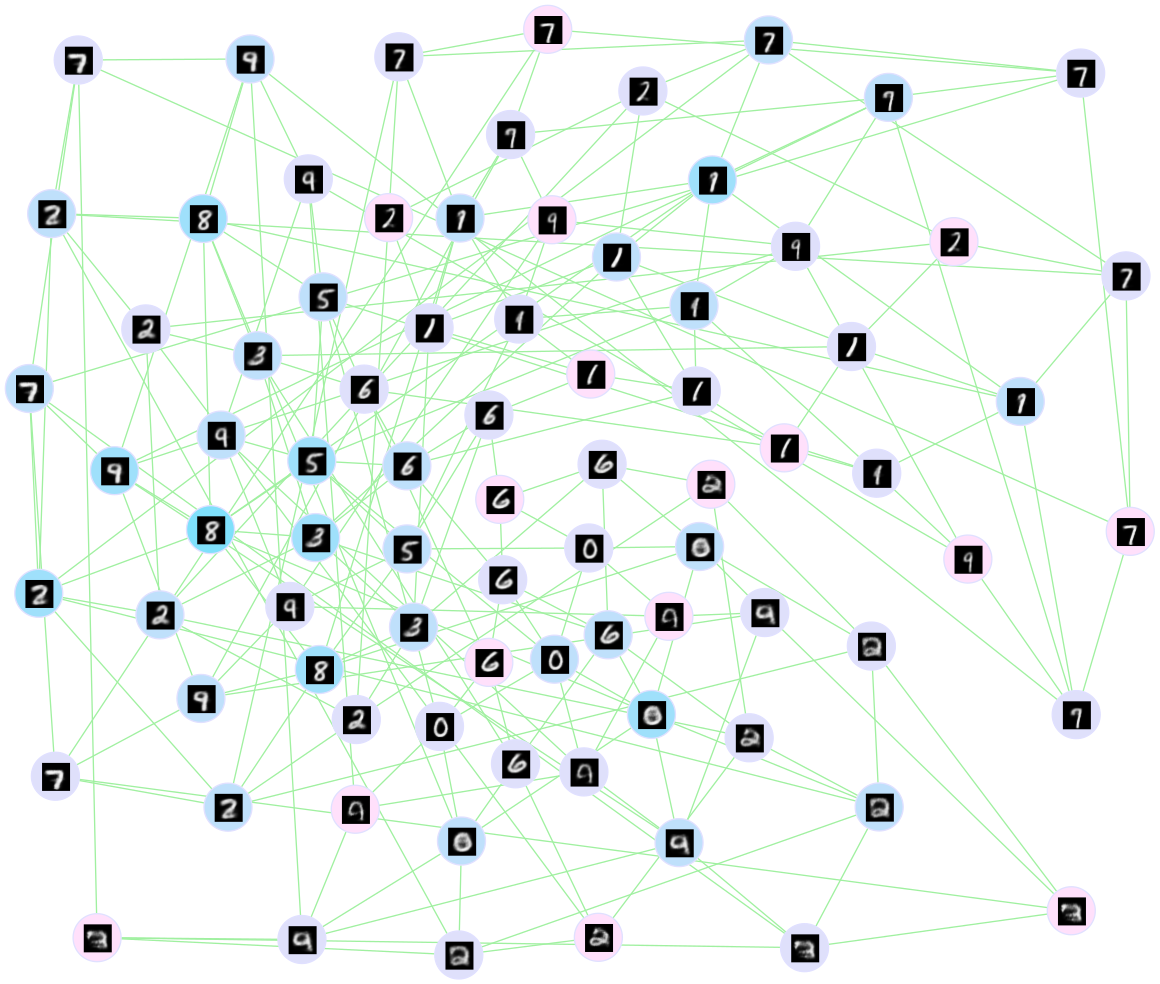

In [337]:
display(Image('tst.png'))